In [1]:

import datetime
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    StandardScaler
)
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    RepeatVector,
    TimeDistributed,
    Dense
)
from tensorflow.keras.optimizers import Adam

import joblib


# Config

In [2]:
# Sequence Length
SEQ_LEN = 240         
# PERIOD_SAMPLES = 24 hours * (60 mins * 2 sample/min) = 2880
PERIOD_DAILY = 2880
PERIOD_WEEKLY = 20160 

# Training Parameters
BATCH_SIZE = 64 
EPOCHS = 1

LEARNING_RATE = 1e-3
VAL_RATIO = 0.1

## Architecture Parameters

In [3]:
# Encoder
FILTERS_1 = 64        # Output channels for the 1st Conv1D layer. Learns 64 local motifs
FILTERS_2 = 128       # Output for 2nd Conv1D . Increases feature depth for abstraction.
KERNEL_SIZE_1 = 3     # Kernel size for the 1st Conv1D. Captures short-term, 3-step, local motifs.
KERNEL_SIZE_2 = 5     # Kernel for the 2nd Conv1D. Captures slightly wider local motifs, 5-step.
LSTM_UNITS = 128      # Hidden size for the lstm encoder/decoder. Defines the capacity to model temporal dependencies.



# Data loading 

In [4]:
current_dir = Path.cwd()
df = pd.read_csv(current_dir.parent / 'data' / 'train_residuals.csv')

with open(current_dir.parent / 'data' / 'metrics.json', 'r') as f:
    METRIC_NAMES = json.load(f)
    
N_FEATURES = len(METRIC_NAMES) 


# CNN+LSTM Autoencoder model

In [5]:
model = Sequential([
    # Encoder
    Input(shape=(SEQ_LEN, N_FEATURES)),  
    
    # CNN blocks for motifs.
    # they find small recurring local features
    Conv1D(filters=FILTERS_1, kernel_size=KERNEL_SIZE_1, activation='relu', padding='same'),
    Conv1D(filters=FILTERS_2, kernel_size=KERNEL_SIZE_2, activation='relu', padding='same'),
    

    # LSTM Encoder, finds the critical features from sequence  
    LSTM(units=LSTM_UNITS, activation='tanh', return_sequences=False),


    # Decoder
    # Repeat Vector (Repeat latent vector SEQ_LEN times)
    RepeatVector(SEQ_LEN),
    
    # LSTM Decoder (Sequence Generation)
    # Generates a reconstructed time sequence based on the compressed context
    LSTM(units=LSTM_UNITS, activation='tanh', return_sequences=True),
    
    # 5CNN Decoder Blocks (Feature Reconstruction)
    # Rebuilds small local features from the generated sequenc
    Conv1D(filters=FILTERS_2, kernel_size=KERNEL_SIZE_2, activation='relu', padding='same'), 
    Conv1D(filters=FILTERS_1, kernel_size=KERNEL_SIZE_1, activation='relu', padding='same'),
    
    # Output layer restores the output features back to N_FEATURES
    # TimeDistributed(Dense(N_FEATURES, activation='sigmoid'))
    TimeDistributed(Dense(N_FEATURES))
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 240, 64)        │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 240, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 240, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 240, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 240, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 240, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 240, 6)         │           390 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,550 (1.57 MB)

 Trainable params: 412,550 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

# Data procession 

In [ ]:
scaled_residuals_df = pd.DataFrame(index=df.index)
scaler_map ={}
for metric in METRIC_NAMES:
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(df[[metric]])
    scaled_residuals_df[metric] = scaled_col.flatten()
    scaler_map[metric] = scaler

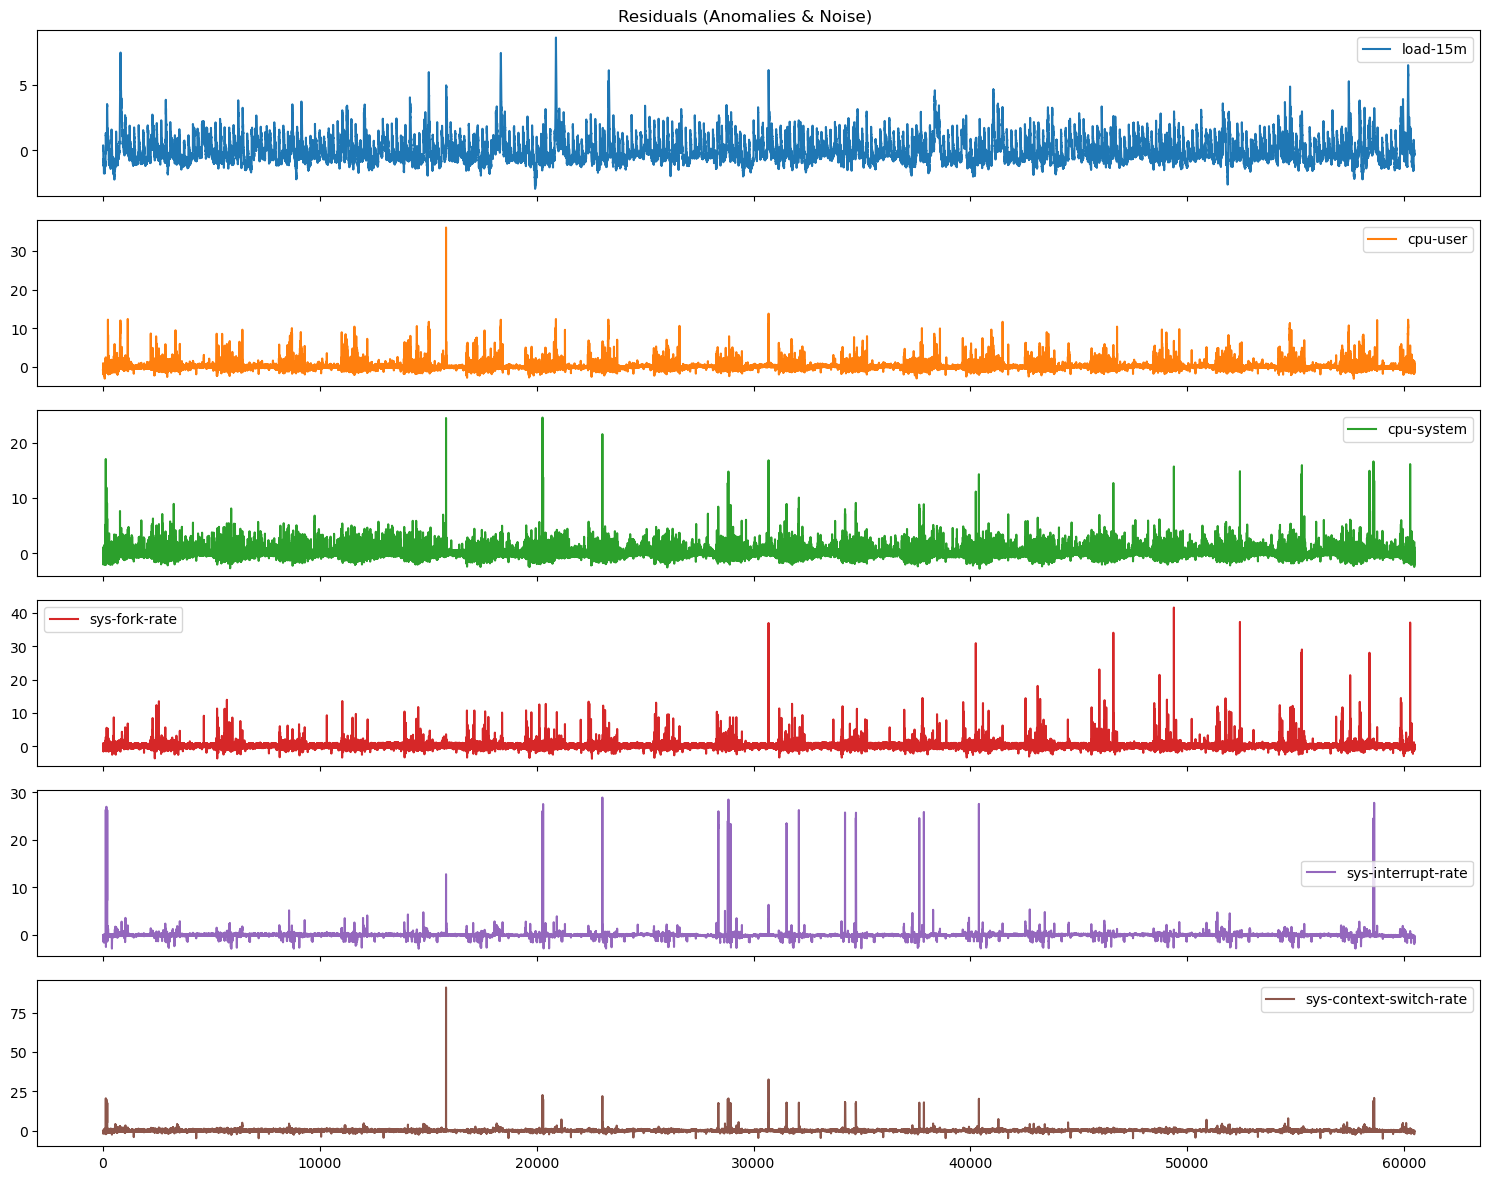

In [7]:
scaled_residuals_df[METRIC_NAMES].plot(
    subplots=True, 
    figsize=(15, 12), 
    title="Residuals (Anomalies & Noise)")

plt.tight_layout() 
plt.show()

In [8]:
def create_sliding_windows(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

X = create_sliding_windows(scaled_residuals_df, SEQ_LEN)
print(f"X shape : {X.shape}")  # (num_windows, SEQ_LEN, N_FEATURES)

X shape : (60235, 240, 6)


# Train model

In [9]:
X_train, X_val = train_test_split(X, test_size=VAL_RATIO, shuffle=False)

print(X_train.shape, X_val.shape)

(54211, 240, 6) (6024, 240, 6)


In [10]:
history = model.fit(
    X_train, X_train,                
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    verbose=1
)


848/848 ━━━━━━━━━━━━━━━━━━━━ 813s 938ms/step - loss: 0.9102 - val_loss: 1.1907


In [11]:
X_train_pred = model.predict(X_train)

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 250s 146ms/step


# Visualize train anomalies by threshold

In [12]:
metric_mse_scores_train = np.mean(np.square(X_train - X_train_pred), axis=1)

In [13]:

def visualize_train_anomalies(mse_train_scores, metric_names, target_metric, p_threshold=0.995):

    metric_index = metric_names.index(target_metric)
    mse_train_target = mse_train_scores[:, metric_index]
    
    threshold_value = np.quantile(mse_train_target, p_threshold)

    anomaly_indices = np.where(mse_train_target > threshold_value)[0]
    anomalous_mse_scores = mse_train_target[anomaly_indices]

    print(f"Anomaly Visualization ({target_metric}) ")
    print(f"Threshold (Theta): {threshold_value:.6f}")
    print(f"Anomalies found in training set: {len(anomaly_indices)} (out of {len(mse_train_target)})")

    plt.figure(figsize=(18, 6))
    plt.plot(mse_train_target, label='MSE (Normal Windows)', 
             color='blue', alpha=0.7)
    plt.axhline(y=threshold_value, color='red', linestyle='--', linewidth=2, 
                label=f'Threshold $\\tau$ ({p_threshold*100:.1f}%)')
    plt.scatter(anomaly_indices, anomalous_mse_scores, 
                color='red', s=50, label='Detected Anomalies (MSE > $\\tau$)', zorder=5)
    plt.xlabel('Window Index (Time Axis)', fontsize=12)
    plt.ylabel('Reconstruction Error (MSE)', fontsize=12)
    plt.title(f'Detected Anomalies in Training Set ({target_metric})', fontsize=16)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    limit = np.quantile(mse_train_target, 0.999) * 1.5 
    plt.ylim(0, limit)
    
    plt.show()

Anomaly Visualization (cpu-user) 
Threshold (Theta): 8.109868
Anomalies found in training set: 543 (out of 54211)


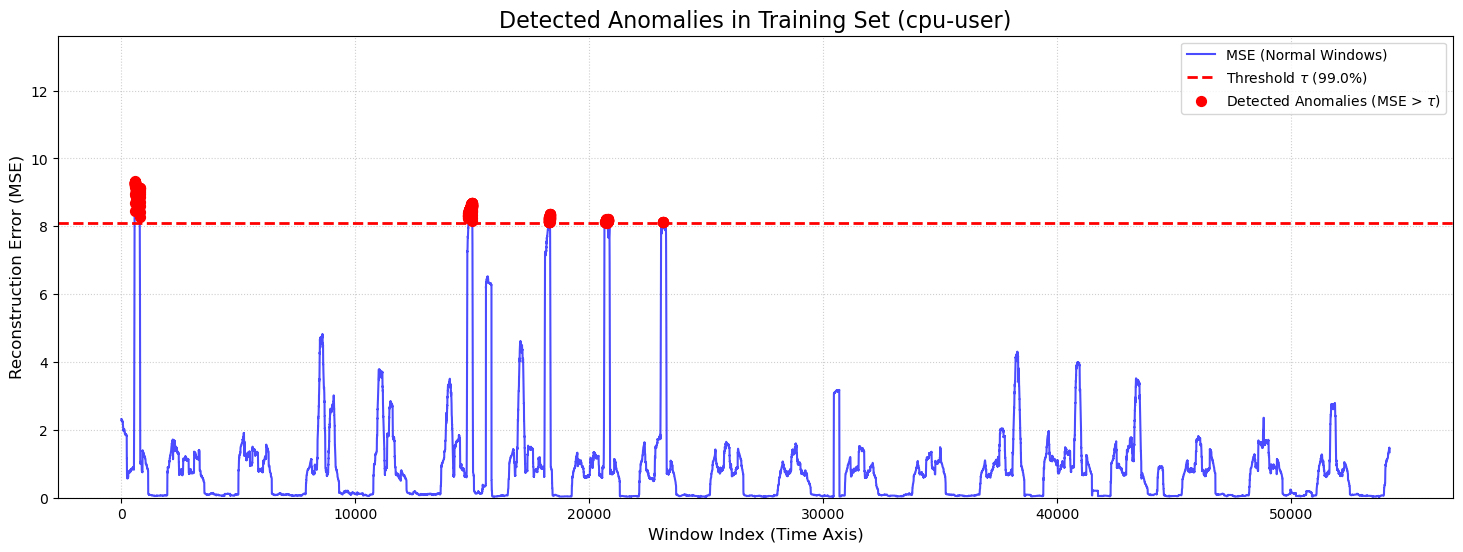

Anomaly Visualization (cpu-user) 
Threshold (Theta): 7.922322
Anomalies found in training set: 814 (out of 54211)


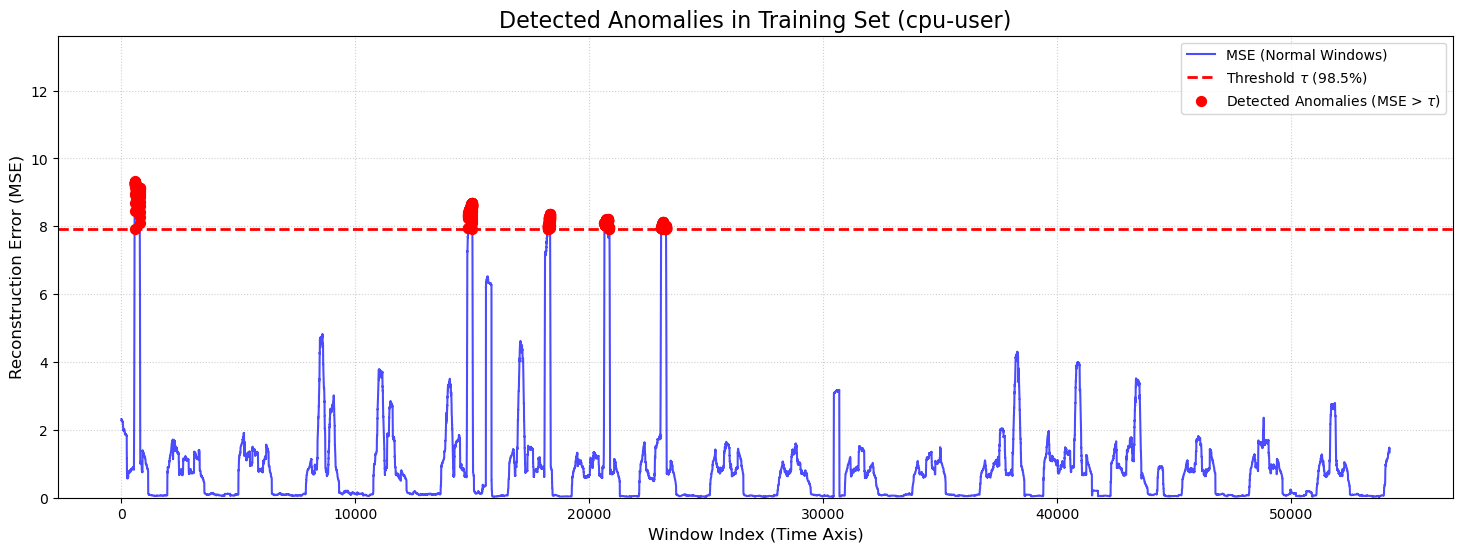

Anomaly Visualization (cpu-user) 
Threshold (Theta): 7.233320
Anomalies found in training set: 1085 (out of 54211)


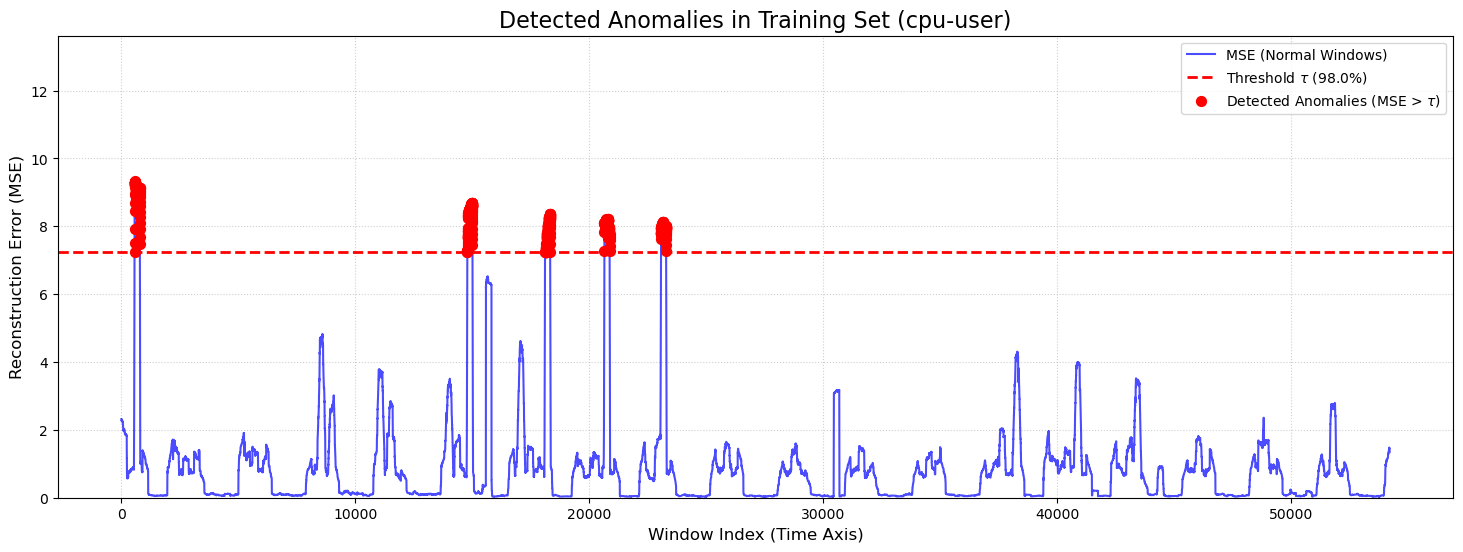

In [14]:
visualize_train_anomalies(
    mse_train_scores=metric_mse_scores_train,
    metric_names=METRIC_NAMES,
    target_metric='cpu-user',
    p_threshold=0.99
)

visualize_train_anomalies(
    mse_train_scores=metric_mse_scores_train,
    metric_names=METRIC_NAMES,
    target_metric='cpu-user',
    p_threshold=0.985
)


visualize_train_anomalies(
    mse_train_scores=metric_mse_scores_train,
    metric_names=METRIC_NAMES,
    target_metric='cpu-user',
    p_threshold=0.98
)


Anomaly Visualization (load-15m) 
Threshold (Theta): 4.655799
Anomalies found in training set: 543 (out of 54211)


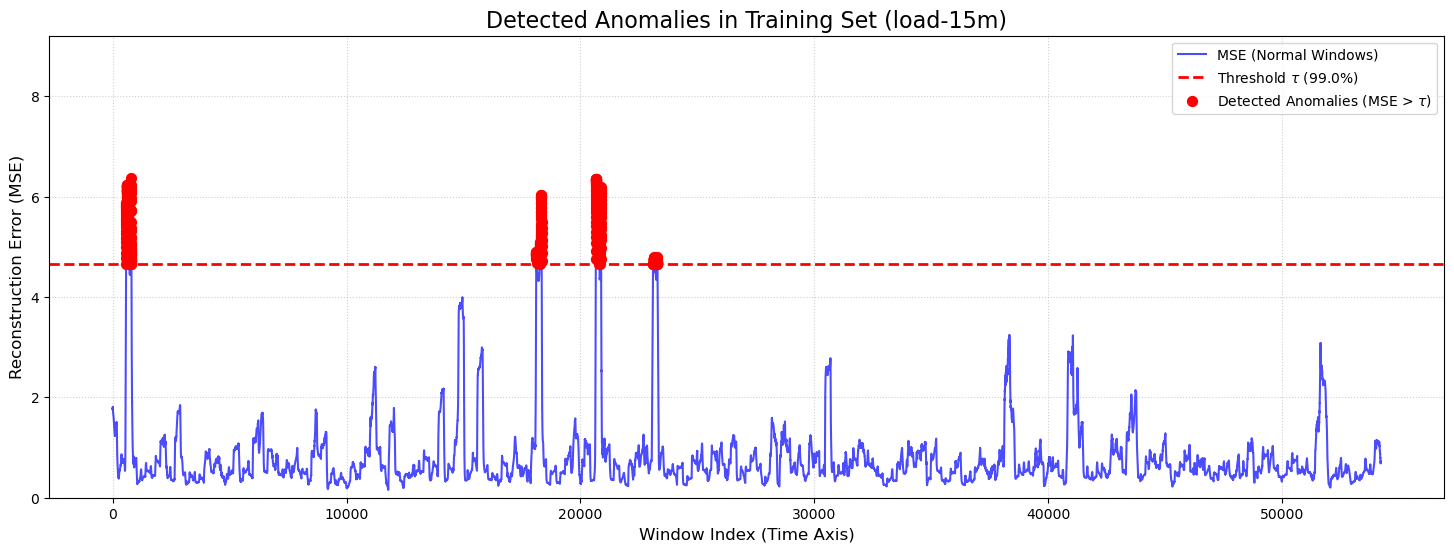

Anomaly Visualization (load-15m) 
Threshold (Theta): 4.385751
Anomalies found in training set: 814 (out of 54211)


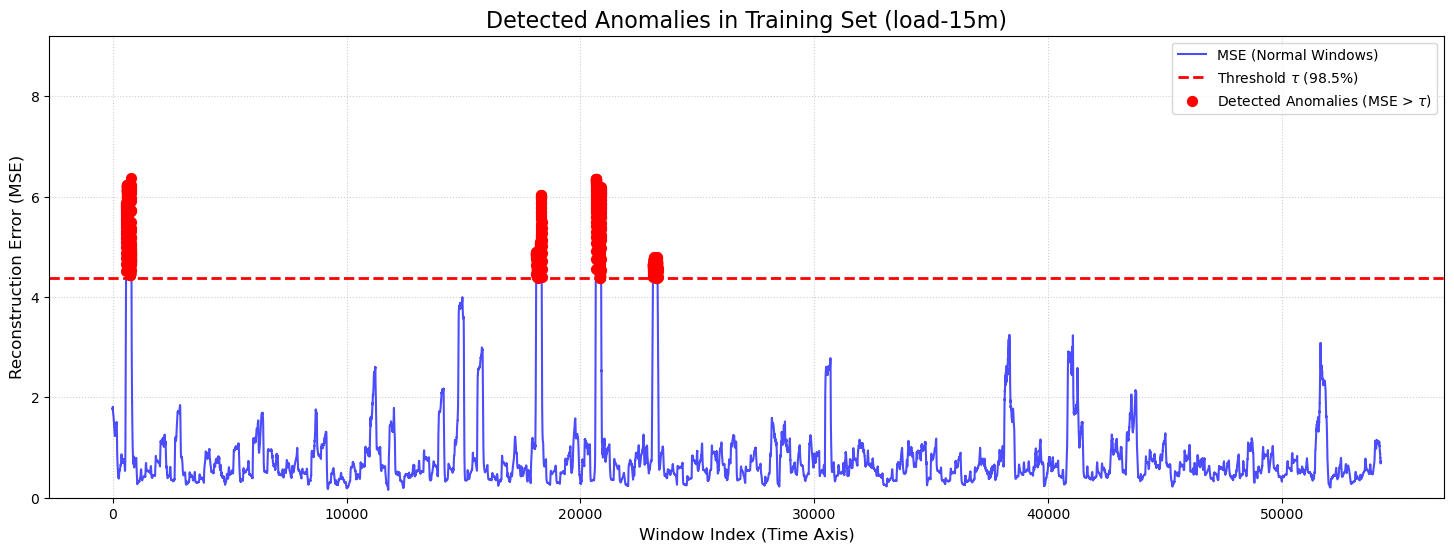

Anomaly Visualization (load-15m) 
Threshold (Theta): 3.788621
Anomalies found in training set: 1085 (out of 54211)


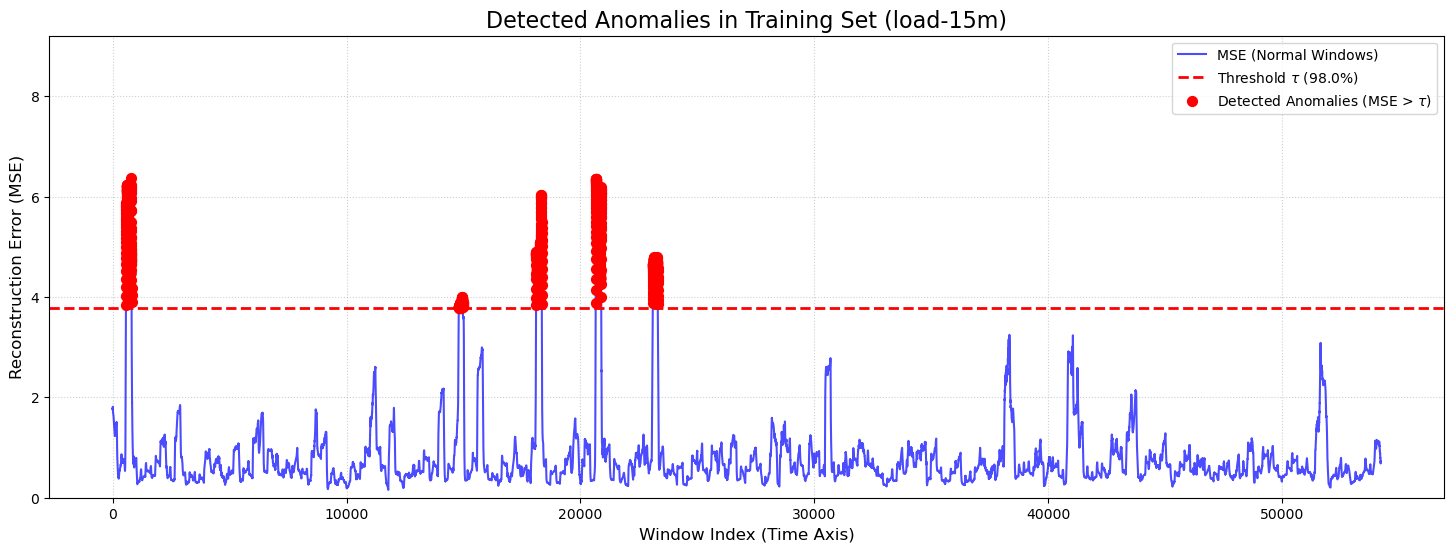

In [15]:

visualize_train_anomalies(
    mse_train_scores=metric_mse_scores_train,
    metric_names=METRIC_NAMES,
    target_metric='load-15m',
    p_threshold=0.99
)

visualize_train_anomalies(
    mse_train_scores=metric_mse_scores_train,
    metric_names=METRIC_NAMES,
    target_metric='load-15m',
    p_threshold=0.985
)


visualize_train_anomalies(
    mse_train_scores=metric_mse_scores_train,
    metric_names=METRIC_NAMES,
    target_metric='load-15m',
    p_threshold=0.98
)


# Savings

In [16]:
current_dir = Path.cwd()
save_dir = current_dir.parent / "models" / "autoencoder"
save_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [17]:

model_filename = f"autoencoder_anomaly_detector_{timestamp}.h5"
model.save(save_dir / model_filename)

In [18]:
scaler_filename = f"autoencoder_anomaly_detector_{timestamp}_scaler_map.pkl"
joblib.dump(scaler_map, save_dir / scaler_filename)

['c:\\Users\\Користувач\\Jupyter\\server-metrics-anomaly-detection\\models\\autoencoder\\autoencoder_anomaly_detector_20260213_185946_scaler_map.pkl']

In [ ]:
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
params_filename = f"autoencoder_anomaly_detector_{timestamp}_parameters.txt"

params = {
    "METRIC_NAMES": METRIC_NAMES,
    "SEQ_LEN": SEQ_LEN,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "LEARNING_RATE": LEARNING_RATE,
    "VAL_RATIO": VAL_RATIO,
    "N_FEATURES": N_FEATURES,
    "FILTERS_1": FILTERS_1,
    "FILTERS_2": FILTERS_2,
    "KERNEL_SIZE_1": KERNEL_SIZE_1,
    "KERNEL_SIZE_2": KERNEL_SIZE_2,
    "LSTM_UNITS": LSTM_UNITS,
    "X_train.shape": X_train.shape,
    "X_val.shape": X_val.shape,
    "Final Training Loss": float(f"{final_train_loss:.6f}"),
    "Final Validation  Loss": float(f"{final_val_loss:.6f}"),
    "Total Training Time (second)": len(history.history['loss']) * 89,
    "SCALER_TYPE": type(next(iter(scaler_map.values()))).__name__,
    "trained at": timestamp
}

with open(save_dir / params_filename, "w") as f:
    json.dump(params, f, indent=4)


In [20]:

metric_mse_filename = f"cnn_lstm_autoencoder_anomaly_{timestamp}_metric_wise_mse_scores.npy"
np.save(save_dir / metric_mse_filename, metric_mse_scores_train)


In [21]:

print(f"METRIC_NAMES: {METRIC_NAMES}")
custom_percentiles_and_vals = {
    'load-15m': 0.99,
    'cpu-user': 0.99,
    'cpu-system':0.99,
    'sys-fork-rate':0.99,
    'sys-interrupt-rate':0.99,
    'sys-context-switch-rate':0.99,

}

final_threshold_map = {}

for metric_name, p in custom_percentiles_and_vals.items():
    metric_index = METRIC_NAMES.index(metric_name)
    mse_for_metric = metric_mse_scores_train[:, metric_index]
    threshold_value = np.quantile(mse_for_metric, p)
    final_threshold_map[metric_name] = {p: threshold_value}

output_filename = f"autoencoder_anomaly_detector_{timestamp}_model_thresholds_with_values.json"
    
with open(save_dir / output_filename, 'w') as f:
    json.dump(final_threshold_map, f, indent=2)



METRIC_NAMES: ['load-15m', 'cpu-user', 'cpu-system', 'sys-fork-rate', 'sys-interrupt-rate', 'sys-context-switch-rate']
